#Setup TF1.x, keras 2.2.4, keras-yolo3

In [1]:
import numpy as np
import os

%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

# 需要安裝 keras 2.2.4 的版本
import pkg_resources
if pkg_resources.get_distribution('keras').version != '2.2.4':
    !pip install keras==2.2.4 # 安裝2.2.4版本的keras

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
     |████████████████████████████████| 317kB 4.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
%cd /content/drive/My Drive/Colab Notebooks/D50 Racoon/keras-yolo3

/content/drive/My Drive/Colab Notebooks/D50 Racoon/keras-yolo3


In [0]:
# 安裝 qqwweee Keras-yolo3
!git clone https://github.com/qqwweee/keras-yolo3
%cd keras-yolo3




In [4]:
# 安裝相關套件 ，將 training 所需要的套件載入
import os
import subprocess
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.utils import get_random_data
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf


Using TensorFlow backend.


# Prepare Training Set (xml parsing)

In [0]:
# 訓練資料集下載
!git clone https://github.com/experiencor/kangaroo.git
!git clone https://github.com/experiencor/raccoon_dataset.git

#!mkdir video
!wget -c 'https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Raccoon.mp4' -O 'video/Raccoon.mp4'  
!wget -c 'https://cvdl.cupoy.com/HomeworkAction.do?op=getHomeworkFileContent&hwid=D49&filepath=Kangaroo.mp4' -O 'video/Kangaroo.mp4'

# 下載測試資料
#!mkdir test
!wget 'https://cdn.abcotvs.com/dip/images/2270054_080217-kgo-shutterstock-kangaroom-raccoon-img.jpg' -O 'test/RacoonKangaroo.jpg'


--2020-04-29 10:04:10--  https://cdn.abcotvs.com/dip/images/2270054_080217-kgo-shutterstock-kangaroom-raccoon-img.jpg
Resolving cdn.abcotvs.com (cdn.abcotvs.com)... 88.221.164.60, 2a02:26f0:7b:892::38de, 2a02:26f0:7b:88e::38de
Connecting to cdn.abcotvs.com (cdn.abcotvs.com)|88.221.164.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test/RacoonKangaroo.jpg’

test/RacoonKangaroo     [ <=>                ] 184.80K  1.10MB/s    in 0.2s    

2020-04-29 10:04:11 (1.10 MB/s) - ‘test/RacoonKangaroo.jpg’ saved [189240]



In [0]:
import xml.etree.ElementTree as ET
annotation_path = 'animals_train.txt'
classes = ["kangaroo", "raccoon"]

def convert_annotation(file_name, list_file):
    in_file = open(file_name)
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in classes:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

try: 
      os.remove(annotation_path)
except:
      pass
if not os.path.exists(annotation_path):
    # 讀取資料位置
    images_dir = ['kangaroo/images', 'raccoon_dataset/images']
    list_file = open(annotation_path, 'w')
    
    for i, annot_path in enumerate(['kangaroo/annots', 'raccoon_dataset/annotations']):
            
            for a in os.listdir(annot_path):
                name = a.split('.')[0]
                list_file.write(os.path.join(images_dir[i], f'{name}.jpg'))
                convert_annotation(os.path.join(annot_path, a), list_file)
                list_file.write('\n')
        
    list_file.close()

In [0]:
# 設定訓練資料來源位置， training data 以及 validation 比例

annotation_path = 'animals_train.txt' 
log_dir = 'logs/000/'
classes_path = 'model_data/animal_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

# 分為 training 以及 validation
val_split = 0.25
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val


# Create YOLO Model using modified .cfg


In [44]:
if not os.path.exists("model_data/yolov3.h5"):
    if not os.path.exists("yolov3.weights"):    
        print("yolov3.weights doesn't exist, downloading...")
        !wget https://pjreddie.com/media/files/yolov3.weights
    else:
        print("yolov3.weights exist")
    print("Converting yolov3.weights to yolo.h5...")
    #Modify yolov3.cfg and convert to h5
    #set filters=(classes + 5)*3, e.g. filters=21
    #set classes=1, the number of custom classes
    !python convert.py d50_yolov3.cfg yolov3.weights model_data/yolov3.h5

else:
    print("model_data/yolov3.h5 exist")

yolov3.weights exist
Converting yolov3.weights to yolo.h5...
Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)




2020-05-03 07:20:00.287910: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-05-03 07:20:00.288125: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1b02bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-03 07:20:00.288158: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-05-03 07:20:00.291416: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-03 07:20:00.402013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but

# Create YOLOv3 model with 9 anchors and 2 classes

In [58]:
input_shape = (416,416)                                                 # multiple of 32, hw

is_tiny_version = len(anchors)==6                                       # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='model_data/tiny_yolo.h5')
else:
    model = create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='model_data/yolov3.h5')   # make sure you know what you freeze
                        
logging = TensorBoard(log_dir=log_dir)

checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', 
                             save_weights_only=True, 
                             save_best_only=True, 
                             period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               verbose=1)

Create YOLOv3 model with 9 anchors and 2 classes.
Load weights model_data/yolov3.h5.
Freeze the first 249 layers of total 252 layers.


# yoloV3模型訓練

In [60]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 第1階段訓練: 先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    history1=model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# 第二階段訓練: Unfreeze and continue training, to fine-tune.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
    print('Unfreeze all of the layers.')

    batch_size=4
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred})      # recompile to apply the change
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history2 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Train on 273 samples, val on 91 samples, with batch size 16.
Epoch 1/50
17/17 [==============================] - 38s 2s/step - loss: 28.5793 - val_loss: 2716.7982
Epoch 2/50
17/17 [==============================] - 22s 1s/step - loss: 24.6964 - val_loss: 745616.1500
Epoch 3/50
17/17 [==============================] - 24s 1s/step - loss: 23.5769 - val_loss: 745914.7914
Epoch 4/50
17/17 [==============================] - 24s 1s/step - loss: 22.7833 - val_loss: 1399.0742
Epoch 5/50
17/17 [==============================] - 24s 1s/step - loss: 21.9730 - val_loss: 989.9930
Epoch 6/50
17/17 [==============================] - 24s 1s/step - loss: 21.5443 - val_loss: 67.2685
Epoch 7/50
17/17 [==============================] - 24s 1s/step - loss: 21.0983 - val_loss: 31.9488
Epoch 8/50
17/17 [==============================] - 24s 1s/step - loss: 20.7352 - val_loss: 28.5476
Epoch 9/50
17/17 [==============================] - 24s 1s/step - loss: 20.6227 - val_loss: 64.4428
Epoch 10/50
17/17 [=======

Text(0.5, 0, 'epochs')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38542 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 38542 missing from current font.
  font.set_text(s, 0, flags=flags)


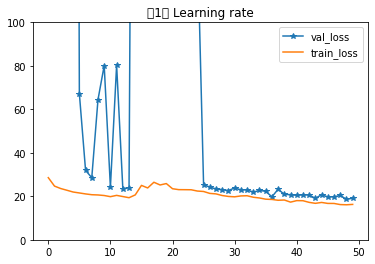

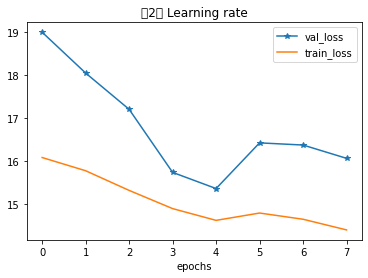

In [62]:
# Plot val_loss vs train_loss

import matplotlib.pyplot as plt

plt.figure()
plt.title('第1階 Learning rate')  
plt.plot(history1.history["val_loss"], "-*" ,  label="val_loss")
plt.plot(history1.history["loss"], label="train_loss")
plt.legend(loc='upper right')
plt.ylim([0, 100])

plt.figure()
plt.title('第2階 Learning rate')  
plt.plot(history2.history["val_loss"], "-*" ,  label="val_loss")
plt.plot(history2.history["loss"], label="train_loss")
plt.legend(loc='upper right')
plt.xlabel("epochs")

# Detect Test Image

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 2 boxes for img
raccoon 0.99 (727, 49) (1280, 660)
kangaroo 0.99 (6, 81) (536, 706)
3.4308550450004986


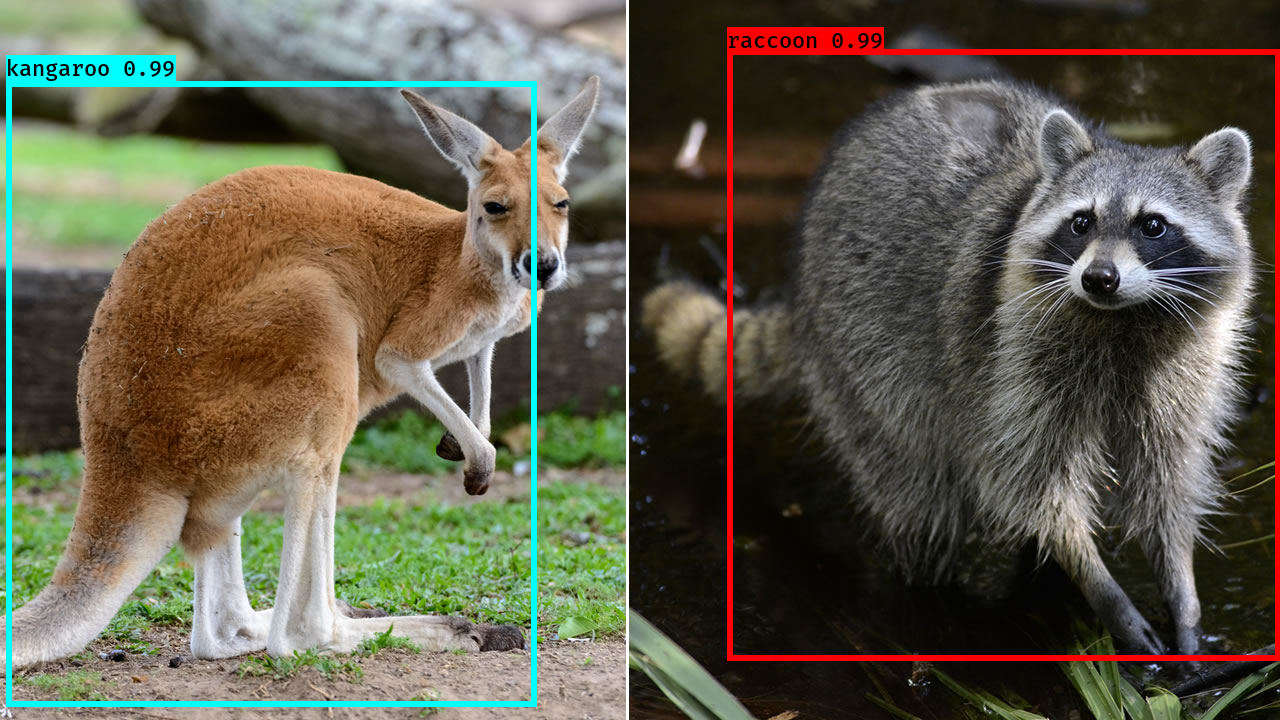

In [64]:
# 載入yolo模型 與 訓練後的權重

from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

from PIL import Image
from IPython import display

for file in os.listdir('test'):
    image = Image.open(os.path.join('test/', file))
    r_img = yolo_model.detect_image(image)
    display.display(r_img)

# Detect Test Video


In [0]:
def video_detect(video_path, output_path):
    import cv2
    import numpy as np
    from PIL import Image
    import timeit

    starttime = timeit.default_timer()
    # Input Video: get 解像度， frame count，編碼

    cap = cv2.VideoCapture(video_path)
    out_w= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH ))
    out_h= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out_fourcc= int(cap.get(cv2.CAP_PROP_FOURCC))
    out_frame=int(cap.get( cv2.CAP_PROP_FRAME_COUNT ))
    print (out_w, out_h, out_frame, out_fourcc)

    # 使用 Input Video 相同 解像度， frame count，編碼
    out = cv2.VideoWriter(output_path, out_fourcc, out_frame, (out_w, out_h))

    k = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            # 寫入影格
            image = Image.fromarray(frame)
            image = np.array(yolo_model.detect_image(image))
            out.write(image)
            k += 1
        else:
            break
        
    # 釋放所有資源
    cap.release()
    out.release()

    #計算 FPS
    print('Time Spent:',round((timeit.default_timer() - starttime), 2), 'Second\nFPS:', round(k/(timeit.default_timer() - starttime), 2))    

In [66]:
video_path = 'video/Kangaroo.mp4'
output_path = 'video/Kangaroo-yolo.mp4'
video_detect(video_path=video_path, output_path=output_path)

Streaming output truncated to the last 5000 lines.
Found 0 boxes for img
0.04462603000138188
(416, 416, 3)
Found 0 boxes for img
0.04412108099859324
(416, 416, 3)
Found 0 boxes for img
0.04419559300004039
(416, 416, 3)
Found 0 boxes for img
0.046635320999484975
(416, 416, 3)
Found 0 boxes for img
0.04418130300109624
(416, 416, 3)
Found 0 boxes for img
0.043926895999902626
(416, 416, 3)
Found 0 boxes for img
0.044019711000146344
(416, 416, 3)
Found 0 boxes for img
0.05005020600219723
(416, 416, 3)
Found 0 boxes for img
0.04862976300137234
(416, 416, 3)
Found 0 boxes for img
0.04302660299799754
(416, 416, 3)
Found 0 boxes for img
0.04400342100052512
(416, 416, 3)
Found 0 boxes for img
0.04665221300092526
(416, 416, 3)
Found 0 boxes for img
0.04566888299814309
(416, 416, 3)
Found 0 boxes for img
0.045756281000649324
(416, 416, 3)
Found 0 boxes for img
0.043907267001486616
(416, 416, 3)
Found 0 boxes for img
0.0450927399979264
(416, 416, 3)
Found 0 boxes for img
0.04375564099973417
(416, 4

In [67]:
video_path = 'video/Raccoon.mp4'
output_path = 'video/Raccoon-yolo.mp4'
video_detect(video_path=video_path, output_path=output_path)    

Streaming output truncated to the last 5000 lines.
Found 0 boxes for img
0.04438038499938557
(416, 416, 3)
Found 0 boxes for img
0.04738346199883381
(416, 416, 3)
Found 0 boxes for img
0.0443555709971406
(416, 416, 3)
Found 0 boxes for img
0.04593531600039569
(416, 416, 3)
Found 0 boxes for img
0.046660790001624264
(416, 416, 3)
Found 0 boxes for img
0.04581334999966202
(416, 416, 3)
Found 0 boxes for img
0.048997055000654655
(416, 416, 3)
Found 0 boxes for img
0.04548728699955973
(416, 416, 3)
Found 0 boxes for img
0.04382662799980608
(416, 416, 3)
Found 0 boxes for img
0.05053791400132468
(416, 416, 3)
Found 0 boxes for img
0.04598052100118366
(416, 416, 3)
Found 0 boxes for img
0.04459587200108217
(416, 416, 3)
Found 0 boxes for img
0.04352105599900824
(416, 416, 3)
Found 0 boxes for img
0.046562635001464514
(416, 416, 3)
Found 0 boxes for img
0.0455682230021921
(416, 416, 3)
Found 0 boxes for img
0.046692972999153426
(416, 416, 3)
Found 0 boxes for img
0.0501534190007078
(416, 416,